In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime

<ipython-input-3-c4af8c81085f>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [202]:
series = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/TSA CODE/US Inflation Dataset .csv')

In [203]:
series.head()

,date,CPI
0,01-01-1947 00:00,21.48
1,01-02-1947 00:00,21.62
2,01-03-1947 00:00,22.00
3,01-04-1947 00:00,22.00
4,01-05-1947 00:00,21.95


In [204]:
series.isnull().sum()

date    0
CPI     0
dtype: int64

In [205]:
series['date'] = pd.to_datetime(series['date'])

In [206]:
series.head()

,date,CPI
0,1947-01-01,21.48
1,1947-01-02,21.62
2,1947-01-03,22.00
3,1947-01-04,22.00
4,1947-01-05,21.95


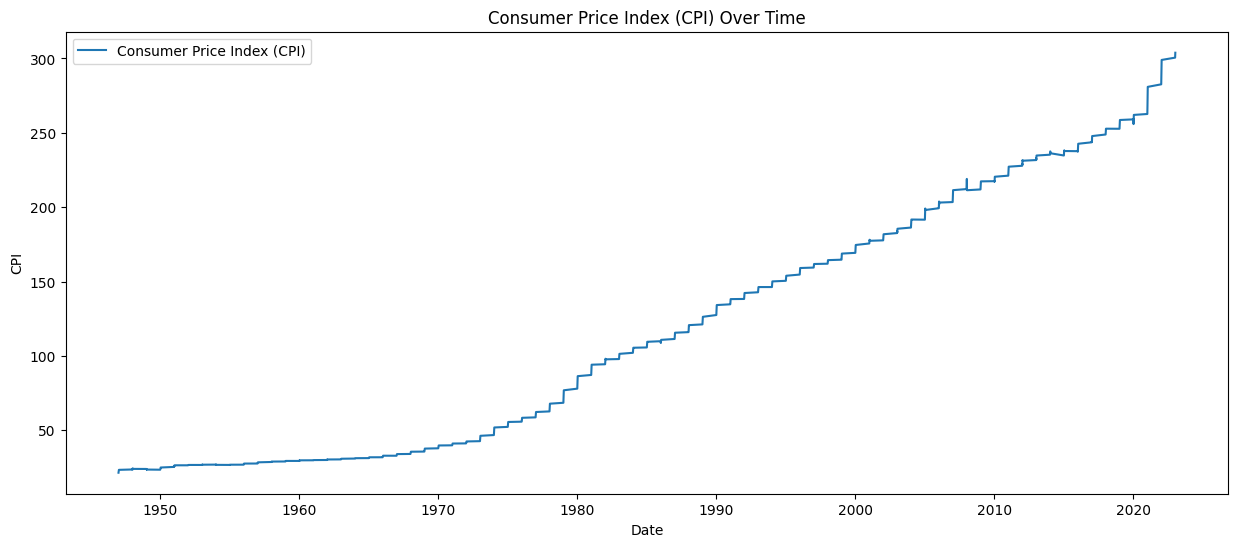

In [229]:
plt.figure(figsize=(15, 6))
plt.plot(series['date'], series['CPI'], label='Consumer Price Index (CPI)')
plt.title('Consumer Price Index (CPI) Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

**Trend Plot**

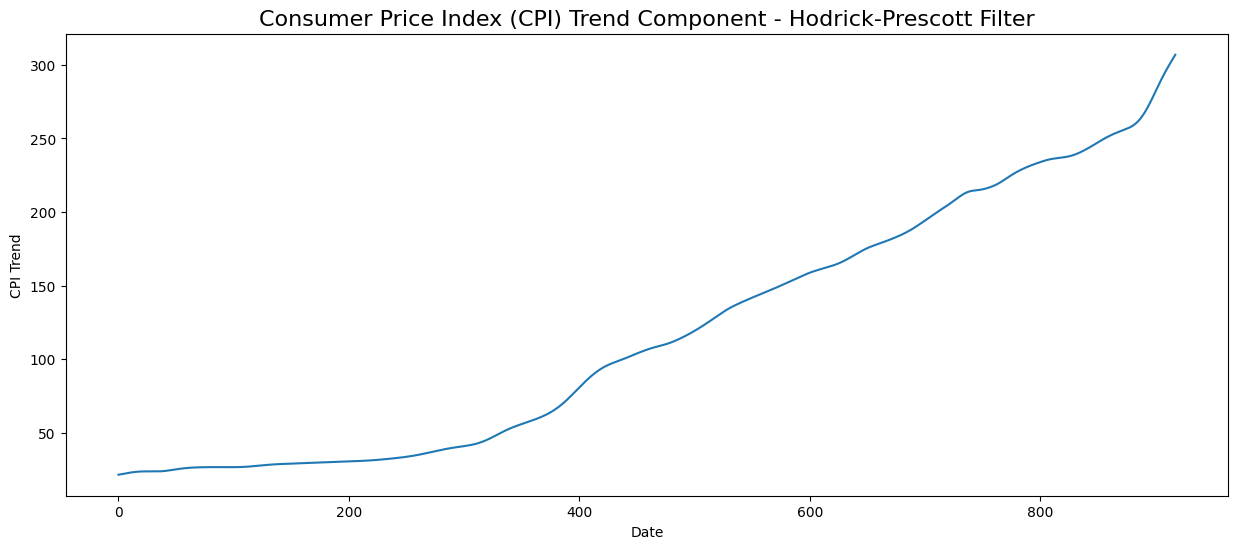

In [207]:
%matplotlib inline
from statsmodels.tsa.filters.hp_filter import hpfilter

CPI_cycle, CPI_trend = hpfilter(series['CPI'], lamb=1600)

plt.figure(figsize=(15,6))
CPI_trend.plot()
plt.title('Consumer Price Index (CPI) Trend Component - Hodrick-Prescott Filter', fontsize=16)
plt.xlabel('Date')
plt.ylabel('CPI Trend')
plt.show()

**Detrending using Pandas Deffierencing**

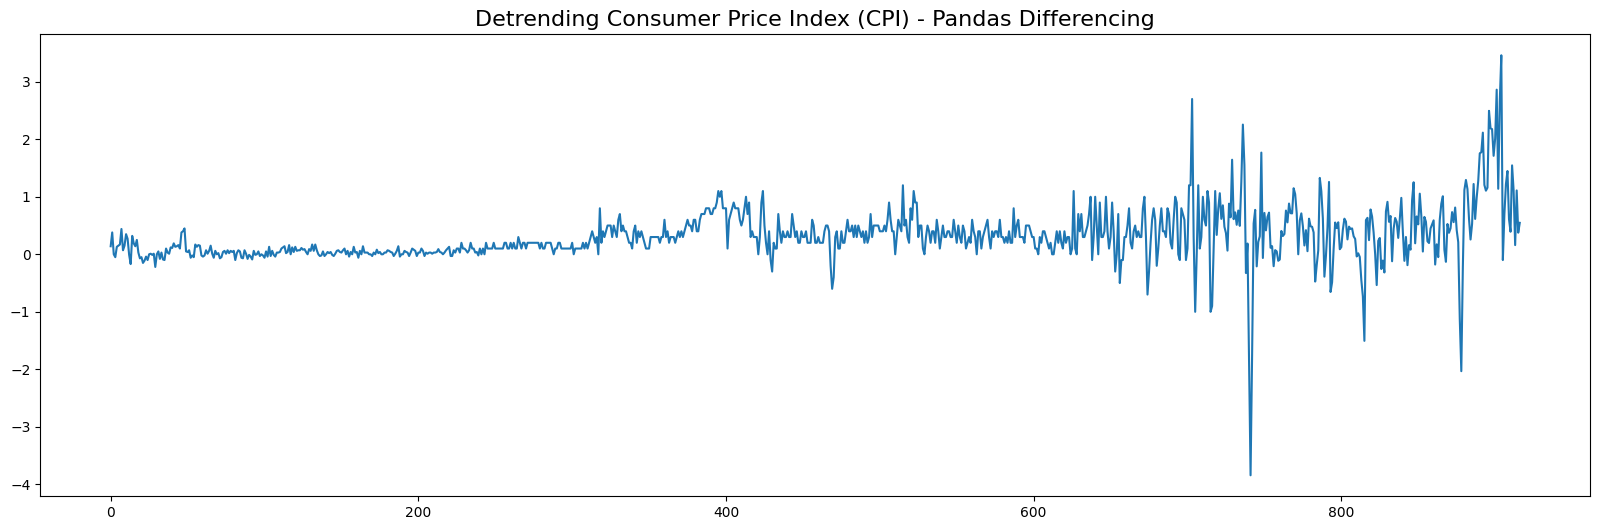

In [218]:
X = series['CPI'].values
diff = list()

for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)

plt.figure(figsize=(20,6))
plt.plot(diff)
plt.title('Detrending Consumer Price Index (CPI) - Pandas Differencing', fontsize=16)
plt.show()

**Seasoning using seasonal_decompos**

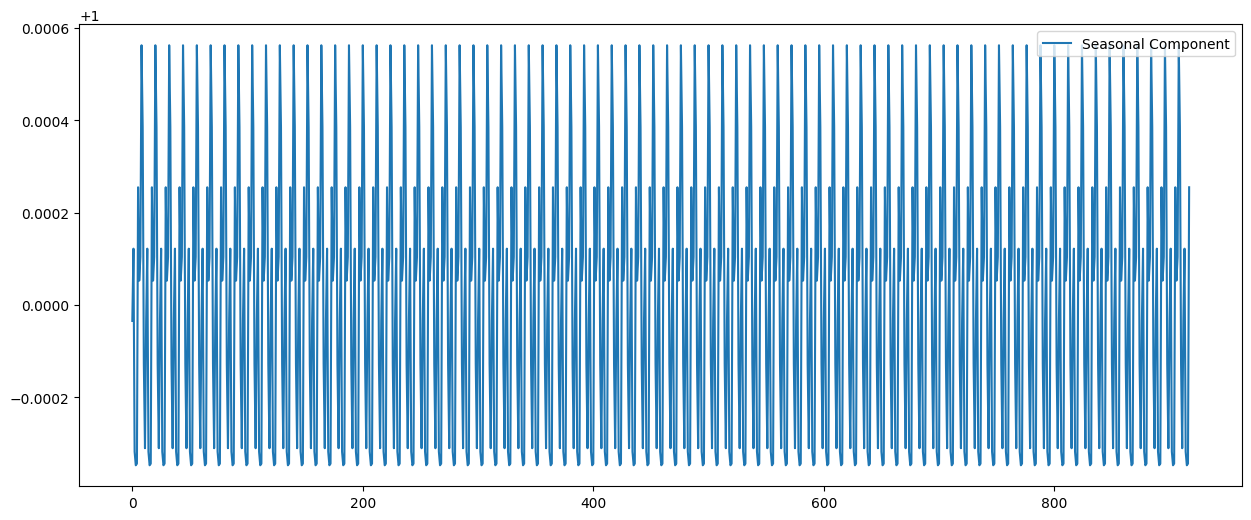

In [214]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(series['CPI'], model='multiplicative', period=12)

plt.figure(figsize=(15,6))
plt.plot(result_mul.seasonal, label='Seasonal Component')
plt.legend()
plt.show()

**Deseasoning using seasonal_decompos**

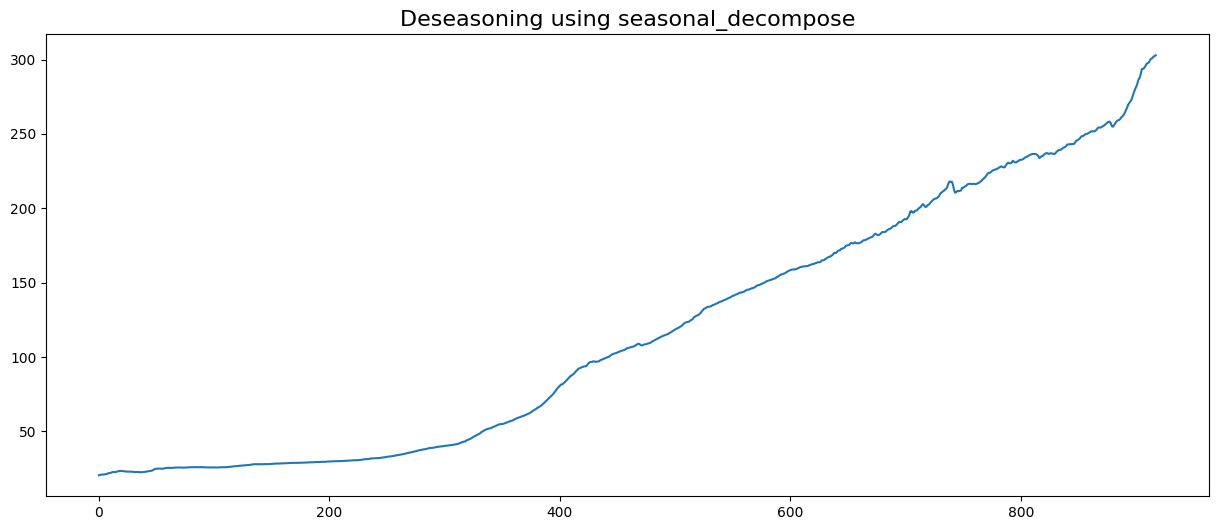

In [219]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(series['CPI'], model='multiplicative', period=12)
deseason = series['CPI'] - result_mul.seasonal
plt.figure(figsize=(15,6))
plt.plot(deseason)
plt.title('Deseasoning using seasonal_decompose', fontsize=16)
plt.show()

**Residual**

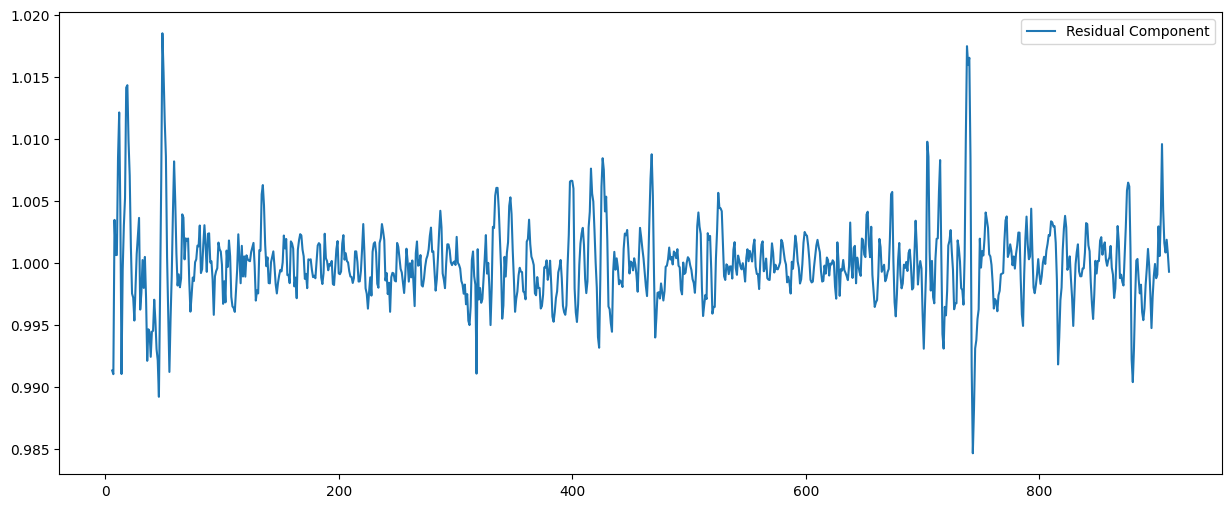

In [215]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(series['CPI'], model='multiplicative', period=12)

plt.figure(figsize=(15,6))
plt.plot(result_mul.resid, label='Residual Component')
plt.legend()
plt.show()

**Extracting Cyclic Variations**

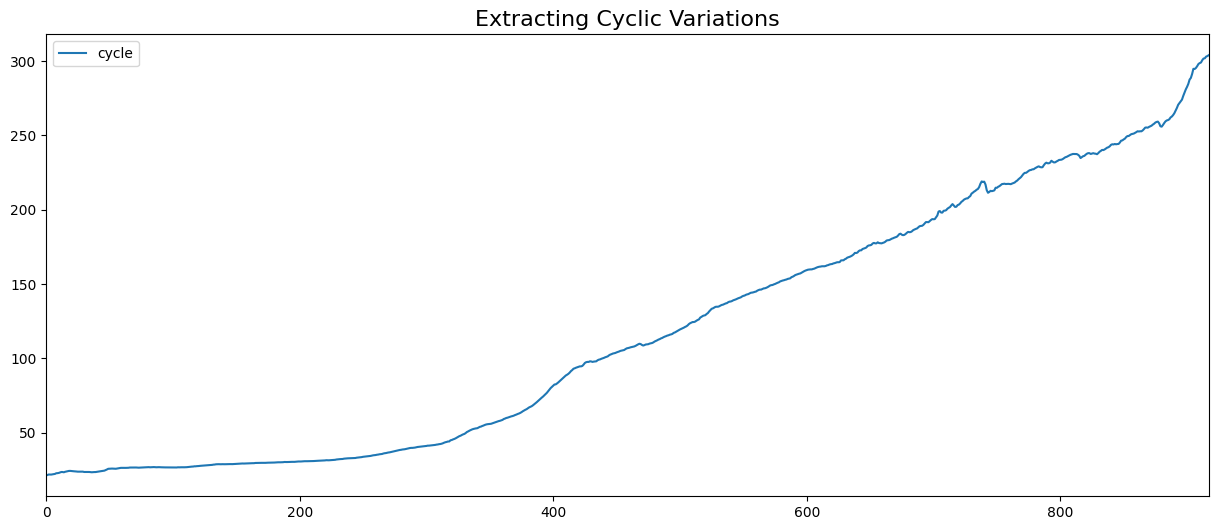

In [220]:
series['cycle'] = series['CPI']
series['trend'] = series['CPI']
series[['cycle']].plot(figsize=(15,6)).autoscale(axis='x',tight=True)
plt.title('Extracting Cyclic Variations', fontsize=16)
plt.show()

**Autocorrelation plot**

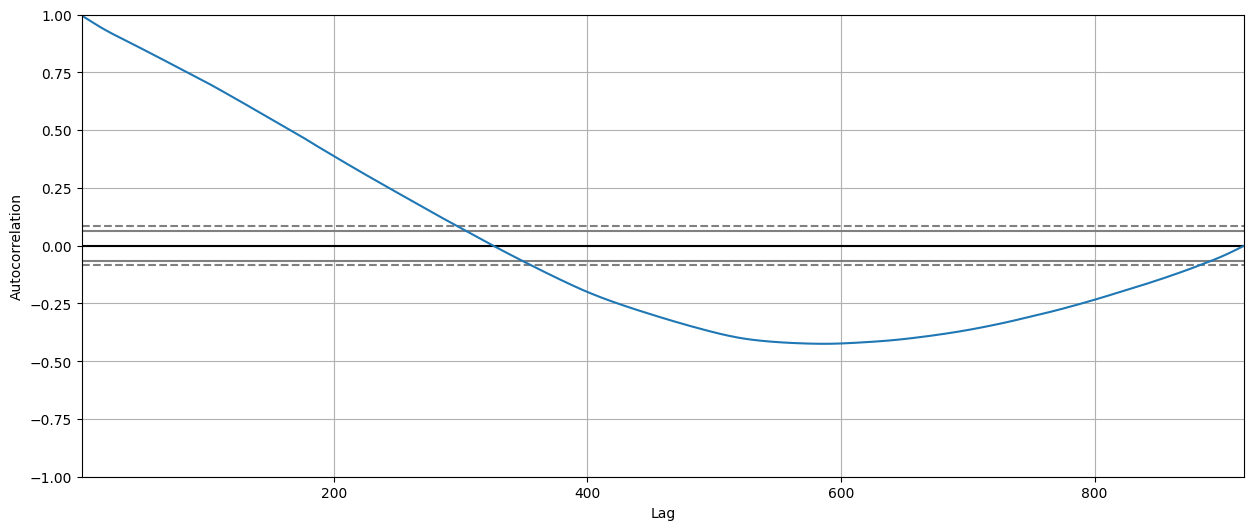

In [216]:
from pandas.plotting import autocorrelation_plot
%matplotlib inline

plt.rcParams.update({'figure.figsize':(15,6)})
autocorrelation_plot(series['CPI'])
plt.show()

**Filters**

In [ ]:
series.agg({'CPI': ['count','min', 'max', 'mean']})

,CPI
count,918.000000
min,21.480000
max,303.841000
mean,117.794828


In [ ]:
threshold = 10
filtered_df = series[series['CPI'] > threshold]
print(len(filtered_df))

918


In [ ]:
lower_threshold = 70
upper_threshold = 75
filtered_df = series[(series['CPI'] > lower_threshold) & (series['CPI'] < upper_threshold)]
print(len(filtered_df))

6


#**Simple Exponential Smoothing**


In [74]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn import metrics

In [75]:
X = series['CPI']
test = X.iloc[-30:]
train = X.iloc[:-30]

In [76]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [77]:
resu = []
temp_df = pd.DataFrame()
for i in [0 , 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    print(f'Fitting for smoothing level= {i}')
    fit_v = SimpleExpSmoothing(np.asarray(train)).fit(i)
    fcst_pred_v= fit_v.forecast(30)
    timeseries_evaluation_metrics_func(test,fcst_pred_v)
    rmse = np.sqrt(metrics.mean_squared_error(test, fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE'])

Fitting for smoothing level= 0
Evaluation metric results:-
MSE is : 70104.75200626667
MAE is : 264.4217333333333
RMSE is : 264.7730197853752
MAPE is : 92.46955948984422
R2 is : -376.1121517292912

Fitting for smoothing level= 0.1
Evaluation metric results:-
MSE is : 970.1924601471806
MAE is : 28.00524081105103
RMSE is : 31.14791261300154
MAPE is : 9.58686244334833
R2 is : -4.218923906968997

Fitting for smoothing level= 0.2
Evaluation metric results:-
MSE is : 876.3538798118699
MAE is : 26.276509139336746
RMSE is : 29.603274815666424
MAPE is : 8.980805133671117
R2 is : -3.714141164961612

Fitting for smoothing level= 0.3
Evaluation metric results:-
MSE is : 838.9159612385174
MAE is : 25.554197580364267
RMSE is : 28.964046009466934
MAPE is : 8.727577748911337
R2 is : -3.5127526196002234

Fitting for smoothing level= 0.4
Evaluation metric results:-
MSE is : 814.7902511622636
MAE is : 25.077705315679133
RMSE is : 28.544531020184298
MAPE is : 8.560529487609623
R2 is : -3.3829739929239633



,smoothing parameter,RMSE
10,1.0,27.486722
9,0.9,27.597765
8,0.8,27.720601
7,0.7,27.860781
6,0.6,28.029675
5,0.5,28.247421
4,0.4,28.544531
3,0.3,28.964046
2,0.2,29.603275
1,0.1,31.147913


In [78]:
fitSES = SimpleExpSmoothing(np.asarray(train)).fit( smoothing_level = 1.0,optimized= False)
fcst_gs_pred = fitSES.forecast(30)
timeseries_evaluation_metrics_func(test,fcst_gs_pred)

Evaluation metric results:-
MSE is : 755.5199072666655
MAE is : 23.86673333333332
RMSE is : 27.48672238130013
MAPE is : 8.135987938609594
R2 is : -3.0641430109927237



In [79]:
fitSESauto = SimpleExpSmoothing(np.asarray(train)).fit( optimized= True, use_brute = True)
fcst_auto_pred = fitSESauto.forecast(30)
timeseries_evaluation_metrics_func(test,fcst_auto_pred)

Evaluation metric results:-
MSE is : 755.5199083362834
MAE is : 23.86673335574145
RMSE is : 27.486722400757124
MAPE is : 8.135987946465415
R2 is : -3.064143016746483



In [80]:
fitSESauto.summary()

Dep. Variable:,endog,No. Observations:,888
Model:,SimpleExpSmoothing,SSE,207.594
Optimized:,True,AIC,-1286.610
Trend:,None,BIC,-1277.032
Seasonal:,None,AICC,-1286.564
Seasonal Periods:,None,Date:,"Tue, 05 Dec 2023"
Box-Cox:,False,Time:,04:45:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,21.480000,l.0,False


In [81]:
df_fcst_gs_pred = pd.DataFrame(fcst_gs_pred, columns=['Close_grid_Search'])
df_fcst_gs_pred["new_index"] = range(889, 919)
df_fcst_gs_pred = df_fcst_gs_pred.set_index("new_index")

In [82]:
df_fcst_auto_pred = pd.DataFrame(fcst_auto_pred, columns=['Close_auto_search'])
df_fcst_auto_pred["new_index"] = range(888, 918)
df_fcst_auto_pred = df_fcst_auto_pred.set_index("new_index")

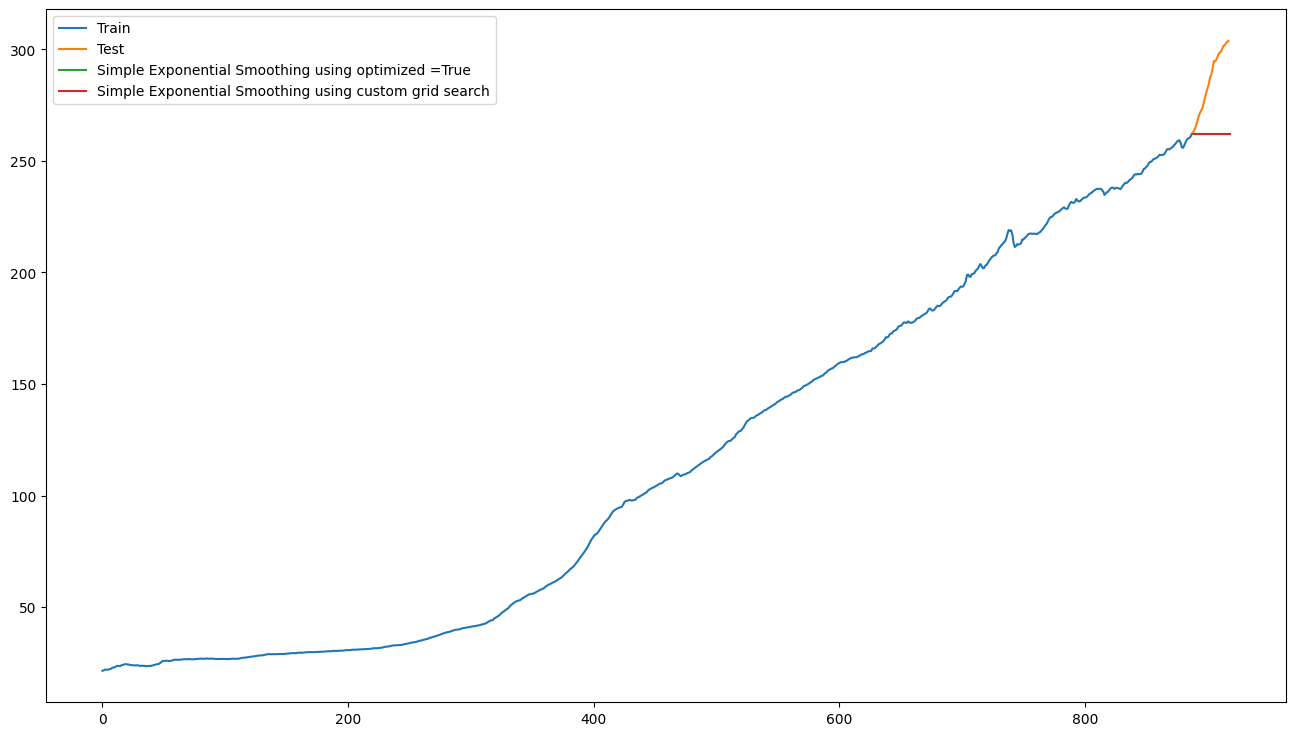

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(df_fcst_auto_pred, label='Simple Exponential Smoothing using optimized =True')
plt.plot(df_fcst_gs_pred, label='Simple Exponential Smoothing using custom grid search')
plt.legend(loc='best')
plt.show()

#**Double Exponential Smoothing**

In [ ]:
from sklearn import metrics
from timeit import default_timer as timer
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
series['CPI'] = series['CPI']

In [ ]:
train = series.CPI[0:-30]
test = series.CPI[-30:]

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damped' : [True, False]}
pg = list(ParameterGrid(param_grid))

In [ ]:
df_results_moni = pd.DataFrame(columns=['smoothing_level', 'smoothing_slope', 'damping_slope','damped','RMSE','r2'])
start = timer()
for a,b in enumerate(pg):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    print(smoothing_level, smoothing_slope, damping_slope,damped)
    fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope = damping_slope ,optimized=False)
    z = fit1.forecast(30)
    print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))}')
    df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')


Streaming output truncated to the last 5000 lines.
904    266.060785
905    266.389923
906    266.719061
907    267.048199
908    267.377336
909    267.706474
910    268.035612
911    268.364750
912    268.693887
913    269.023025
914    269.352163
915    269.681301
916    270.010438
917    270.339576
dtype: float64
 RMSE is 23.037659639071496
0.2 0.3 0.8 False
888    260.724447
889    261.134845
890    261.545242
891    261.955640
892    262.366038
893    262.776436
894    263.186834
895    263.597232
896    264.007630
897    264.418028
898    264.828426
899    265.238824
900    265.649221
901    266.059619
902    266.470017
903    266.880415
904    267.290813
905    267.701211
906    268.111609
907    268.522007
908    268.932405
909    269.342803
910    269.753200
911    270.163598
912    270.573996
913    270.984394
914    271.394792
915    271.805190
916    272.215588
917    272.625986
dtype: float64
 RMSE is 21.735702858813518
0.2 0.4 0.8 False
888    260.752170
889    261.287794

In [ ]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


,smoothing_level,smoothing_slope,damping_slope,damped,RMSE,r2
746,0.2,0.9,0.1,False,3.181992,0.945535


In [ ]:
fit1 = Holt(train,damped =False ).fit(smoothing_level=0.9, smoothing_slope=0.6, damping_slope = 0.1 ,optimized=False)

In [ ]:
Forecast_custom_pred = fit1.forecast(30)

In [ ]:
fit1.summary()

Dep. Variable:,CPI,No. Observations:,888
Model:,Holt,SSE,136.024
Optimized:,False,AIC,-1658.012
Trend:,Additive,BIC,-1638.856
Seasonal:,None,AICC,-1657.917
Seasonal Periods:,None,Date:,"Mon, 04 Dec 2023"
Box-Cox:,False,Time:,16:44:14
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
smoothing_trend,0.6000000,beta,False


In [ ]:
timeseries_evaluation_metrics_func(test,Forecast_custom_pred)

Evaluation metric results:-
MSE is : 144.73141229160143
MAE is : 10.31865851992715
RMSE is : 12.030436911916434
MAPE is : 3.5140905857277707
R2 is : 0.2214511463184965



In [ ]:
fitESAUTO = Holt(train).fit(optimized= True, use_brute = True)
fitESAUTO.summary()

Dep. Variable:,CPI,No. Observations:,888
Model:,Holt,SSE,122.297
Optimized:,True,AIC,-1752.478
Trend:,Additive,BIC,-1733.322
Seasonal:,None,AICC,-1752.382
Seasonal Periods:,None,Date:,"Mon, 04 Dec 2023"
Box-Cox:,False,Time:,16:44:14
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.0949665,beta,True


In [ ]:
fitESAUTOpred = fitESAUTO.forecast(30)
timeseries_evaluation_metrics_func(test,fitESAUTOpred)

Evaluation metric results:-
MSE is : 379.06053539956974
MAE is : 16.83845038554365
RMSE is : 19.46947701915924
MAPE is : 5.737577340299547
R2 is : -1.0390676815661615



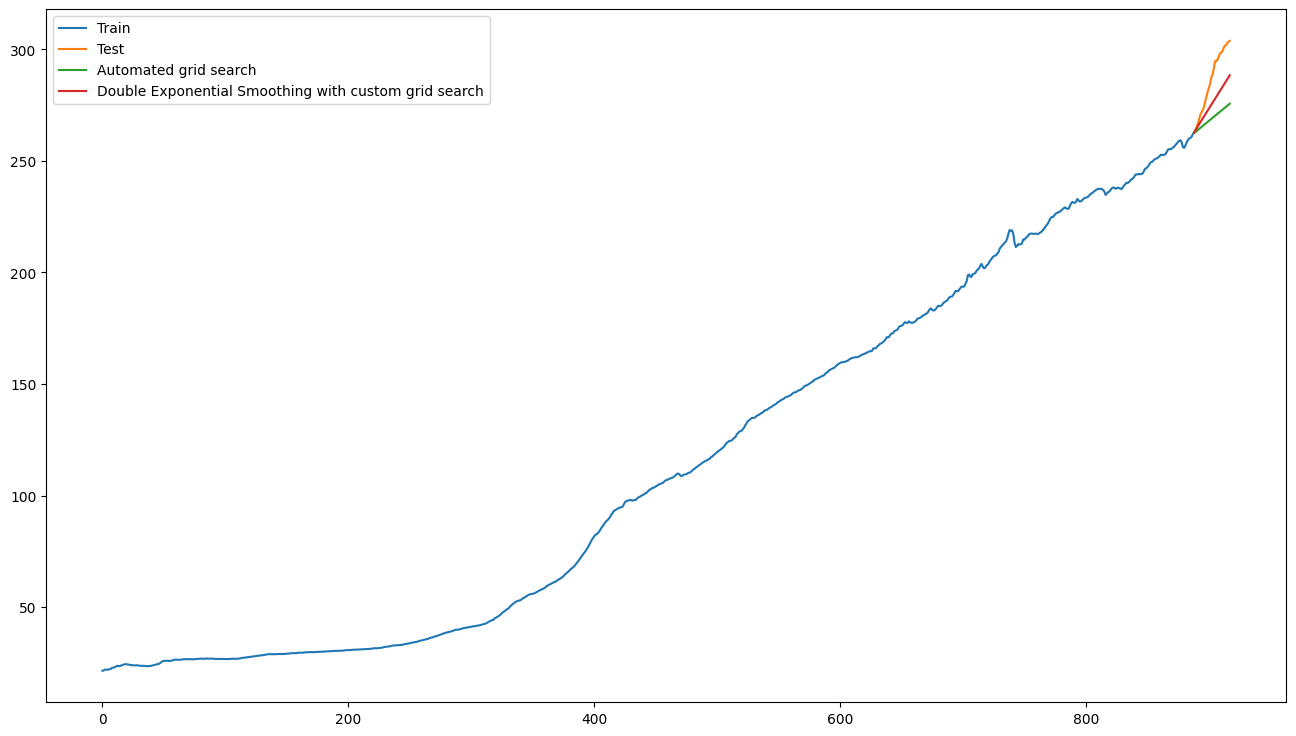

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(fitESAUTOpred, label='Automated grid search')
plt.plot(Forecast_custom_pred, label='Double Exponential Smoothing with custom grid search')
plt.legend(loc='best')
plt.show()

#**Triple Exponential Smoothing**

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn import metrics
from timeit import default_timer as timer
from sklearn.model_selection import ParameterGrid

In [ ]:
X = series['CPI']
test = X.iloc[-30:]
train = X.iloc[:-30]

In [63]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'trend': ['add', 'mul'],
              'seasonal' :['add', 'mul'],
              'seasonal_periods':[3,6,12],
              'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damped' : [True, False],
              'use_boxcox':[True, False],
              'remove_bias':[True, False],
              'use_basinhopping':[True, False]}
pg = list(ParameterGrid(param_grid))

In [ ]:
df_results_moni = pd.DataFrame(columns=['trend', 'seasonal_periods', 'damped', 'use_boxcox', 'use_basinhopping', 'RMSE', 'r2'])
start = timer()
print('Starting Grid Search..')
for a, b in enumerate(pg):
    trend = b.get('trend')
    seasonal_periods = b.get('seasonal_periods')
    damped = b.get('damped')
    use_boxcox = b.get('use_boxcox')
    use_basinhopping = b.get('use_basinhopping')

    model = ExponentialSmoothing(train, trend=trend, damped=damped, seasonal_periods=seasonal_periods, use_boxcox=use_boxcox)

    fit1 = model.fit(smoothing_level=smoothing_level,
                     smoothing_slope=smoothing_slope,
                     damping_slope=damping_slope,
                     optimized=False)

    z = fit1.forecast(30)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)

    df_results_moni = df_results_moni.append({'trend': trend, 'seasonal_periods': seasonal_periods,
                                              'damped': damped, 'use_boxcox': use_boxcox,
                                              'use_basinhopping': use_basinhopping,
                                              'RMSE': RMSE, 'r2': r2}, ignore_index=True)

print('End of Grid Search')
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Starting Grid Search..


Streaming output truncated to the last 5000 lines.
<ipython-input-22-4b5e511a211a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'trend': trend, 'seasonal_periods': seasonal_periods,
<ipython-input-22-4b5e511a211a>:23: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'trend': trend, 'seasonal_periods': seasonal_periods,
<ipython-input-22-4b5e511a211a>:11: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train, trend=trend, damped=damped, seasonal_periods=seasonal_periods, use_boxcox=use_boxcox)
<ipython-input-22-4b5e511a211a>:13: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 

End of Grid Search
 Total time taken to complete grid search in seconds: 5692.4784082179995


<ipython-input-22-4b5e511a211a>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_moni = df_results_moni.append({'trend': trend, 'seasonal_periods': seasonal_periods,
<ipython-input-22-4b5e511a211a>:23: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_results_moni = df_results_moni.append({'trend': trend, 'seasonal_periods': seasonal_periods,
<ipython-input-22-4b5e511a211a>:11: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train, trend=trend, damped=damped, seasonal_periods=seasonal_periods, use_boxcox=use_boxcox)
<ipython-input-22-4b5e511a211a>:13: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = model.fit(smoothing_level=smoothing_level,
/usr/l

In [ ]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


,trend,seasonal_periods,damped,use_boxcox,use_basinhopping,RMSE,r2
69985,add,3,False,False,True,2.71561,0.688007


In [ ]:
df_results_moni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139968 entries, 0 to 139967
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   trend             139968 non-null  object 
 1   seasonal_periods  139968 non-null  object 
 2   damped            139968 non-null  object 
 3   use_boxcox        139968 non-null  object 
 4   use_basinhopping  139968 non-null  object 
 5   RMSE              139968 non-null  float64
 6   r2                139968 non-null  float64
dtypes: float64(2), object(5)
memory usage: 7.5+ MB


In [ ]:
fit1 = ExponentialSmoothing(train, trend='mul', damped=False, seasonal_periods=3, use_boxcox=False).fit(smoothing_level=0.9,
                                                                                            smoothing_slope=0.6,
                                                                                            damping_slope=0.6,
                                                                                            optimized=False,
                                                                                            method='Powell')
Forecast_custom_pred = fit1.forecast(30)
fit1.summary()


<ipython-input-25-f2fa75d85afa>:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  fit1 = ExponentialSmoothing(train, trend='mul', damped=False, seasonal_periods=3, use_boxcox=False).fit(smoothing_level=0.9,
<ipython-input-25-f2fa75d85afa>:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = ExponentialSmoothing(train, trend='mul', damped=False, seasonal_periods=3, use_boxcox=False).fit(smoothing_level=0.9,
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead.
  return func(*args, **kwargs)


Dep. Variable:,CPI,No. Observations:,1273
Model:,ExponentialSmoothing,SSE,202.180
Optimized:,False,AIC,-2334.284
Trend:,Multiplicative,BIC,-2313.687
Seasonal:,None,AICC,-2334.218
Seasonal Periods:,None,Date:,"Thu, 16 Nov 2023"
Box-Cox:,False,Time:,13:17:17
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
smoothing_trend,0.6000000,beta,False


In [ ]:
timeseries_evaluation_metrics_func(test,Forecast_custom_pred)

Evaluation metric results:-
MSE is : 111.92405342305928
MAE is : 9.12563077631977
RMSE is : 10.579416497286571
MAPE is : 3.476859364451765
R2 is : -3.735152213243177



In [ ]:
fitESAUTO = ExponentialSmoothing(train).fit(optimized= True, use_brute = True)

In [ ]:
fitESAUTO.summary()

Dep. Variable:,CPI,No. Observations:,1273
Model:,ExponentialSmoothing,SSE,266.541
Optimized:,True,AIC,-1986.468
Trend:,None,BIC,-1976.170
Seasonal:,None,AICC,-1986.437
Seasonal Periods:,None,Date:,"Thu, 16 Nov 2023"
Box-Cox:,False,Time:,13:17:17
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,9.7999998,l.0,True


In [ ]:
fitESAUTOpred = fitESAUTO.forecast(30)
timeseries_evaluation_metrics_func(test,fitESAUTOpred)

Evaluation metric results:-
MSE is : 88.15629371796585
MAE is : 8.03240000734313
RMSE is : 9.38915830721614
MAPE is : 3.059263458126585
R2 is : -2.729613577629234



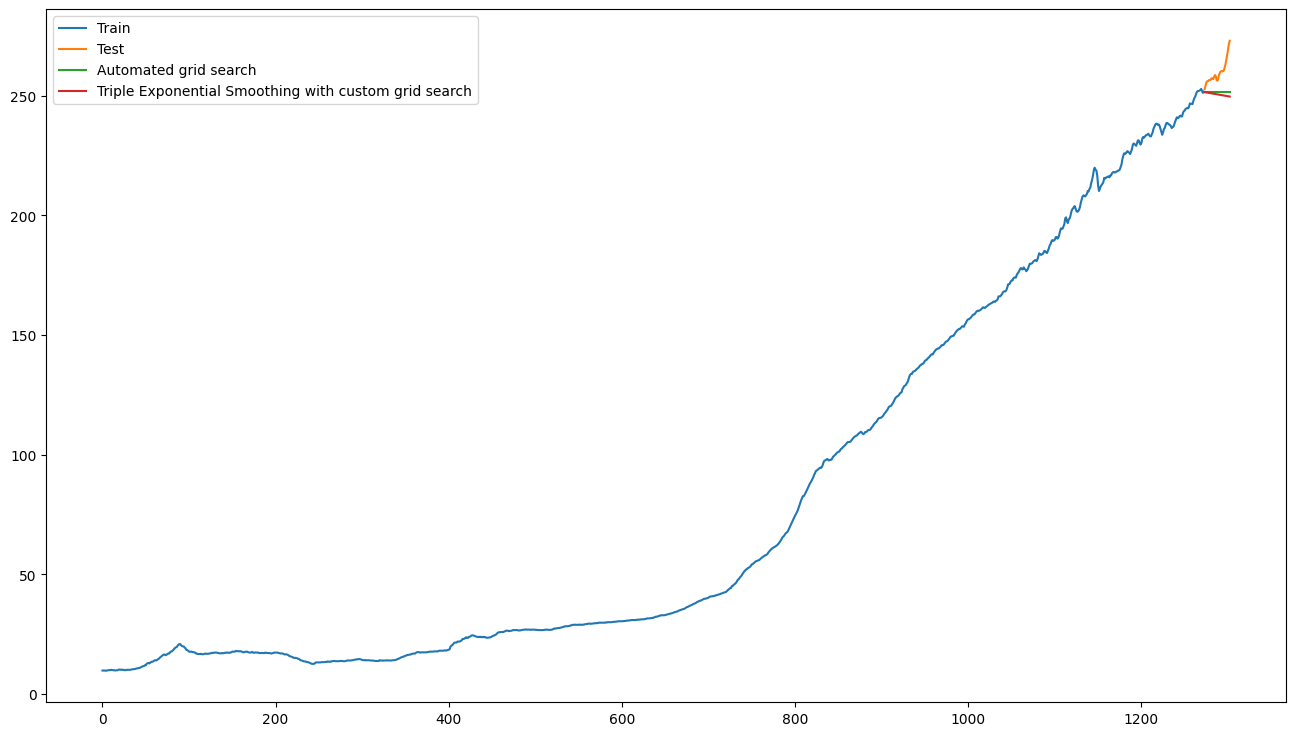

In [ ]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(fitESAUTOpred, label='Automated grid search')
plt.plot(Forecast_custom_pred, label='Triple Exponential Smoothing with custom grid search')
plt.legend(loc='best')
plt.show()

#**Test for stationary using ADF test**

In [84]:
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller

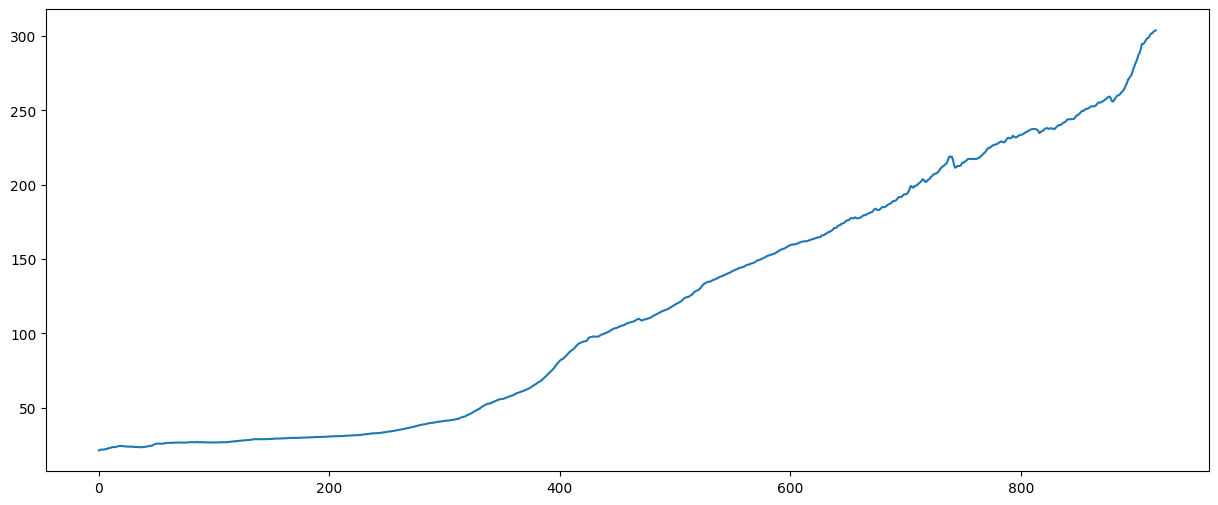

In [85]:
series['CPI'].plot(figsize=(15,6))
pyplot.show()

In [86]:
def Augmented_Dickey_Fuller_Test_func(series, column_name):
    print(f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='aic')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")


In [87]:
Augmented_Dickey_Fuller_Test_func(series['CPI'], 'CPI')

Results of Dickey-Fuller Test for column: CPI
Test Statistic                   2.678867
p-value                          0.999086
#Lags Used                      15.000000
Number of Observations Used    902.000000
Critical Value (1%)             -3.437621
Critical Value (5%)             -2.864750
Critical Value (10%)            -2.568479
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


<Axes: >

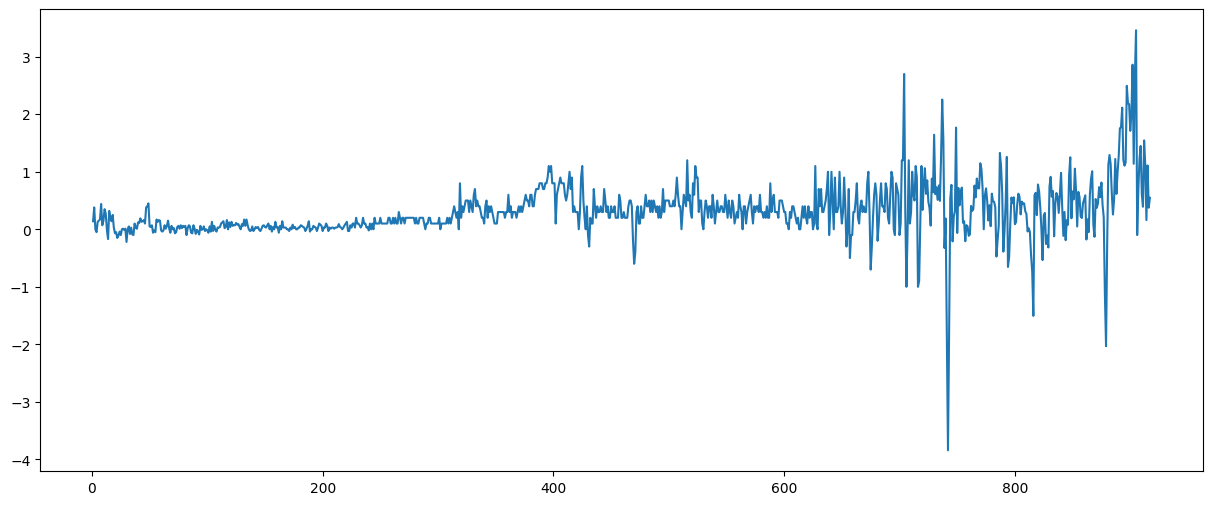

In [88]:
series['CPI'].diff().plot(figsize=(15,6))

In [89]:
Augmented_Dickey_Fuller_Test_func(series['CPI'].diff().dropna(),'CPI')

Results of Dickey-Fuller Test for column: CPI
Test Statistic                  -3.582730
p-value                          0.006100
#Lags Used                      14.000000
Number of Observations Used    902.000000
Critical Value (1%)             -3.437621
Critical Value (5%)             -2.864750
Critical Value (10%)            -2.568479
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


#**ARIMA Model**

In [90]:
pip install pmdarima

In [91]:
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")

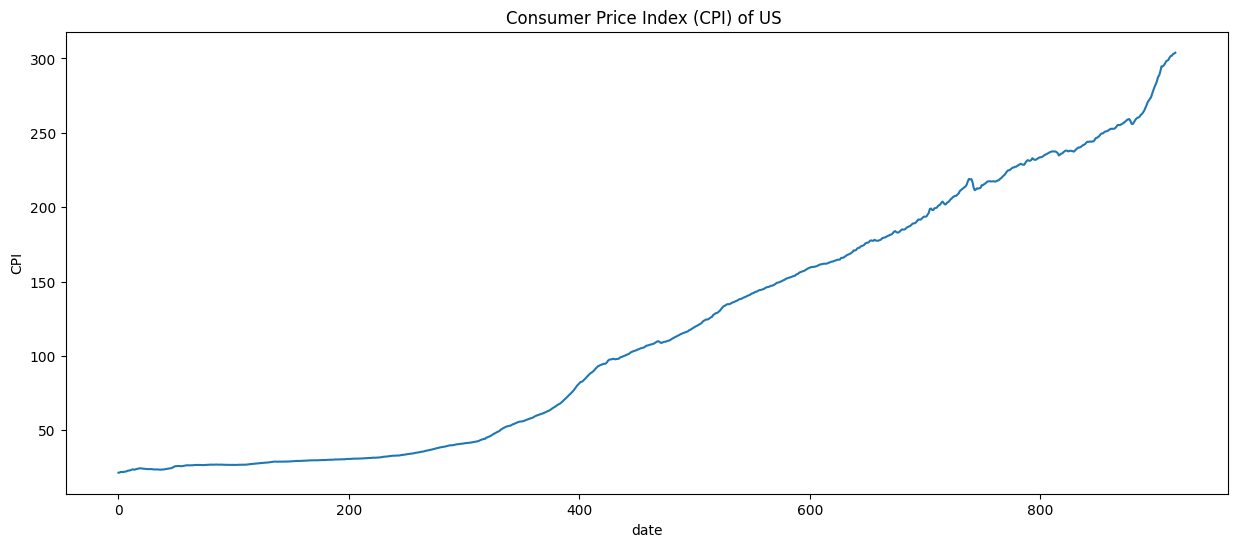

In [92]:
series["CPI"].plot(figsize=(15, 6))
plt.xlabel("Date")
plt.ylabel("CPI")
plt.title("Consumer Price Index (CPI) of US ")
plt.show()

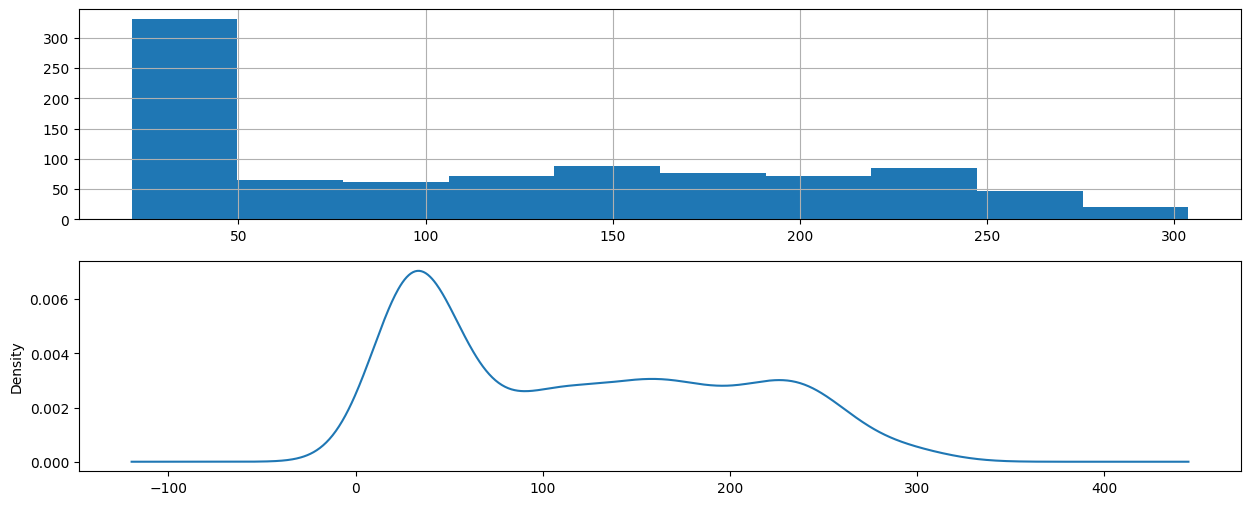

In [93]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
series["CPI"].hist()
plt.subplot(212)
series["CPI"].plot(kind='kde')
plt.show()

In [94]:
X = series[['CPI' ]]
train, test = X[0:-30], X[-30:]

In [95]:
stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=7, max_q=7, seasonal=False,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=581.019, Time=3.29 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=837.418, Time=0.30 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=823.822, Time=0.22 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=767.297, Time=0.77 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=835.427, Time=0.23 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=550.208, Time=6.97 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=743.174, Time=0.77 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=552.018, Time=5.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=552.064, Time=4.28 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=554.401, Time=6.46 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=693.453, Time=1.53 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=554.098, Time=4.40 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=548.866, Time=0.92 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=580.106, Time=0.60 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=741.1

In [96]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  888
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -270.433
Date:                Tue, 05 Dec 2023   AIC                            548.866
Time:                        04:50:04   BIC                            568.013
Sample:                             0   HQIC                           556.186
                                - 888                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5372      0.015     35.444      0.000       0.508       0.567
ar.L2         -0.1966      0.019    -10.183      0.000      -0.234      -0.159
ma.L1         -0.9722      0.007   -136.479      0.000      -0.986      -0.958
sigma2         0.1075      0.002     46.238      0.000       0.103       0.112
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11248.15
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              37.11   Skew:                            -1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['cpi_pred'])

In [99]:
df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = range(888, 918)
df_conf = df_conf.set_index("new_index")

In [100]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 413.3841762708186
MAE is : 17.508433783255523
RMSE is : 20.33185127505163
MAPE is : 5.962870106150854
R2 is : -1.223703696867707



In [102]:
forecast["new_index"] = range(888, 918)
forecast = forecast.set_index("new_index")

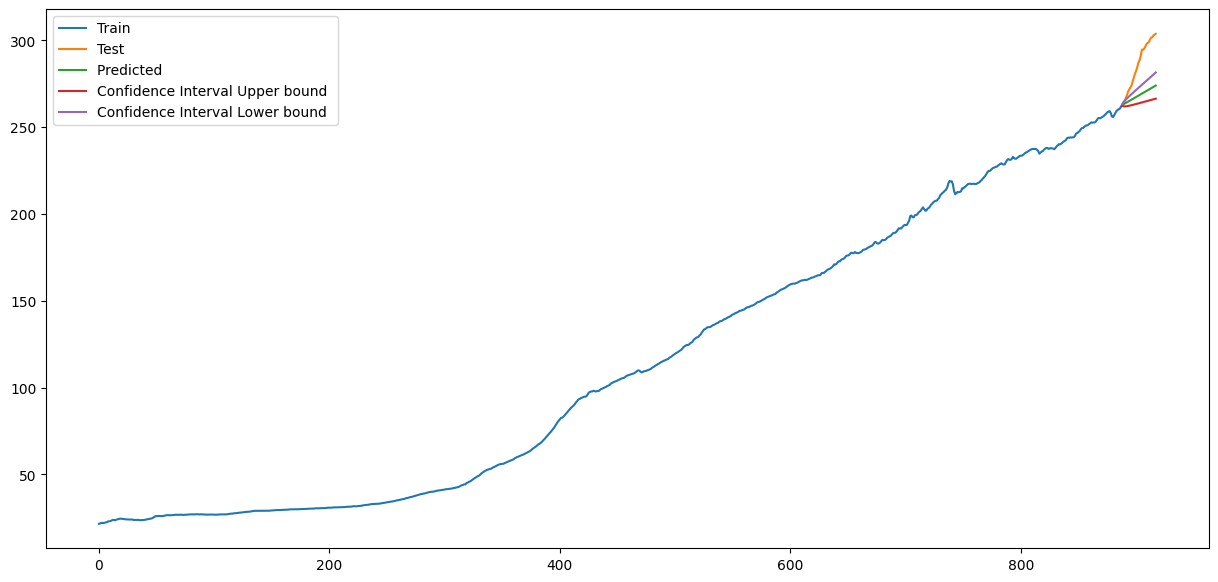

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

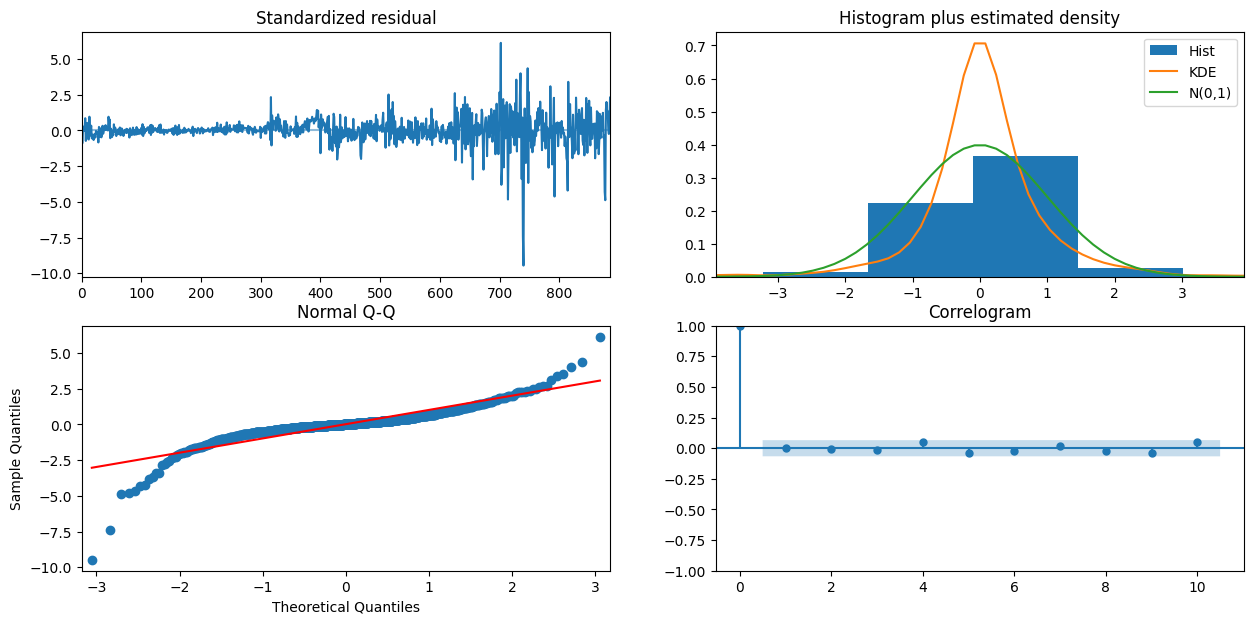

In [104]:
stepwise_model.plot_diagnostics();

In [105]:
forecast

,cpi_pred
new_index,
888,262.842078
889,263.289589
890,263.625526
891,263.972230
892,264.346657
893,264.733862
894,265.122479
895,265.509341
896,265.894984


#**CNN Model**

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [114]:
def train_split_sequence(sequence, steps):
  X, y = list(), list()
  for start in range(0, len(sequence)-30):
    end_index = start + steps
    if end_index > len(sequence)-1:
      break
    sequence_x, sequence_y = sequence[start: end_index], sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return np.array(X), np.array(y)


def test_split_sequence(sequence, steps):
  X, y = list(), list()
  for start in range(len(sequence)-30, len(sequence)):
    end_index = start + steps
    if end_index > len(sequence)-1:
      break
    sequence_x, sequence_y = sequence[start: end_index], sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return np.array(X), np.array(y)

In [115]:
raw_sequence = series['CPI']
steps = 30

X, y = train_split_sequence(raw_sequence, steps)

In [121]:
print("**************************************")
print("The input to the CNN:\n", raw_sequence)
print("**************************************")
print("The features (X), lagged values of the time series, for our CNN Model")
print(X)
print("**************************************")
print("The first 50 observed values (y) of the sequence for training our CNN Model")
print(y[:50])
print("**************************************")

**************************************
The input to the CNN:
 0       21.480
1       21.620
2       22.000
3       22.000
4       21.950
        ...   
913    301.648
914    301.808
915    302.918
916    303.294
917    303.841
Name: CPI, Length: 918, dtype: float64
**************************************
The features (X), lagged values of the time series, for our CNN Model
[[ 21.48   21.62   22.    ...  23.92   23.91   23.92 ]
 [ 21.62   22.     22.    ...  23.91   23.92   23.7  ]
 [ 22.     22.     21.95  ...  23.92   23.7    23.7  ]
 ...
 [260.286 260.813 262.035 ... 300.536 301.648 301.808]
 [260.813 262.035 262.65  ... 301.648 301.808 302.918]
 [262.035 262.65  263.638 ... 301.808 302.918 303.294]]
**************************************
The first 50 observed values (y) of the sequence for training our CNN Model
[23.7  23.7  23.75 23.67 23.7  23.61 23.51 23.61 23.64 23.65 23.77 23.88
 24.07 24.2  24.34 24.5  24.6  24.98 25.38 25.83 25.88 25.92 25.99 25.93
 25.91 25.86 26.03 26.16 26.

In [122]:
features = 1
X = X.reshape((X.shape[0], X.shape[1], features))

print("After reshaping, the shape of input X")
print(X.shape)
print("**************************************")
print("**************************************")
print("The final form of input feature matrix X is")
print(X)
print("**************************************")
print("**************************************")
print("Feature matrix X is ready for input to CNN model. We have used feature engineering to convert\n"
,"a sequence to matrix with image matrix shape to find patterns in sequence")
print("**************************************")
print("**************************************")

After reshaping, the shape of input X
(888, 30, 1)
**************************************
**************************************
The final form of input feature matrix X is
[[[ 21.48 ]
  [ 21.62 ]
  [ 22.   ]
  ...
  [ 23.92 ]
  [ 23.91 ]
  [ 23.92 ]]

 [[ 21.62 ]
  [ 22.   ]
  [ 22.   ]
  ...
  [ 23.91 ]
  [ 23.92 ]
  [ 23.7  ]]

 [[ 22.   ]
  [ 22.   ]
  [ 21.95 ]
  ...
  [ 23.92 ]
  [ 23.7  ]
  [ 23.7  ]]

 ...

 [[260.286]
  [260.813]
  [262.035]
  ...
  [300.536]
  [301.648]
  [301.808]]

 [[260.813]
  [262.035]
  [262.65 ]
  ...
  [301.648]
  [301.808]
  [302.918]]

 [[262.035]
  [262.65 ]
  [263.638]
  ...
  [301.808]
  [302.918]
  [303.294]]]
**************************************
**************************************
Feature matrix X is ready for input to CNN model. We have used feature engineering to convert
 a sequence to matrix with image matrix shape to find patterns in sequence
**************************************
**************************************


In [123]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(steps, features)))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(1))

In [124]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 100)               89700     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 89993 (351.54 KB)
Trainable params: 89993 (351.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [125]:
model.compile(optimizer="adam", loss="mse")

In [127]:
model.fit(X, y, epochs=50, verbose=1)

Epoch 1/50
28/28 [==============================] - 0s 6ms/step - loss: 4.4041
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 6.5640
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 7.4408
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 4.6375
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 3.8757
Epoch 6/50
28/28 [==============================] - 0s 5ms/step - loss: 4.0007
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 4.7699
Epoch 8/50
28/28 [==============================] - 0s 5ms/step - loss: 4.3414
Epoch 9/50
28/28 [==============================] - 0s 5ms/step - loss: 3.2321
Epoch 10/50
28/28 [==============================] - 0s 5ms/step - loss: 4.0575
Epoch 11/50
28/28 [==============================] - 0s 5ms/step - loss: 7.9923
Epoch 12/50
28/28 [==============================] - 0s 5ms/step - loss: 3.3252
Epoch 13/50
28/28 [==============================

In [128]:
x_test, y_test = train_split_sequence(raw_sequence, steps)

x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], features))
y_pred = model.predict(x_test, verbose=0)

print(f"The next predicted output vs original is:")
data = pd.DataFrame(y_pred, columns=['y_pred'])
data["y_test"] = y_test
data.head()

The next predicted output vs original is:


,y_pred,y_test
0,24.859650,23.70
1,24.794044,23.70
2,24.749296,23.75
3,24.652191,23.67
4,24.572624,23.70


In [129]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)

2.0255437658217654

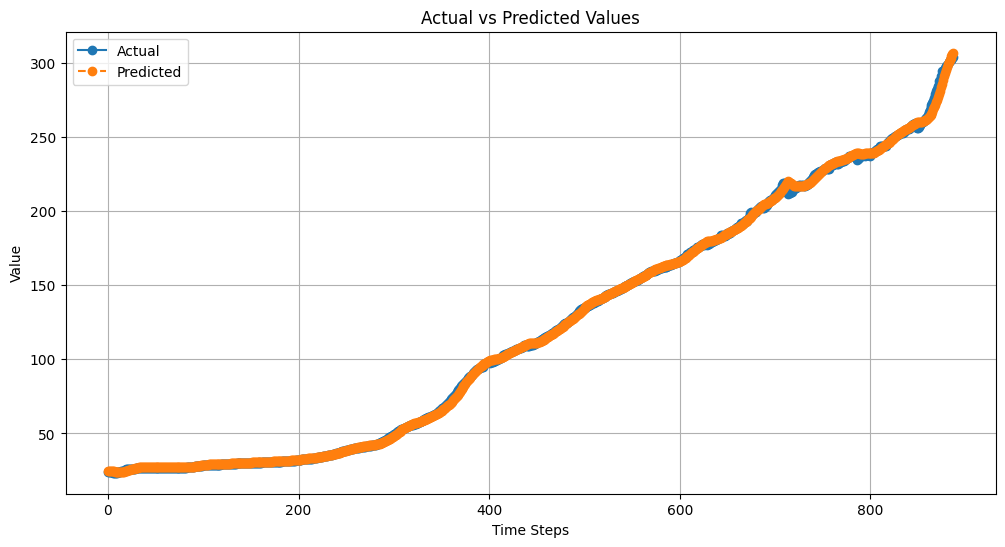

In [130]:
plt.figure(figsize=(12, 6))
plt.plot(data['y_test'], label='Actual', marker='o')
plt.plot(data['y_pred'], label='Predicted', linestyle='dashed', marker='o')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [131]:
def timeseries_evaluation_metrics_func(y_true, y_pred , model_name):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'Evaluation metric results for {model_name}:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [132]:
from sklearn import metrics
timeseries_evaluation_metrics_func(y_test, y_pred , 'CNN')

Evaluation metric results for CNN:-
MSE is : 2.0255437658217654
MAE is : 0.8014242008484159
RMSE is : 1.4232159940858469
MAPE is : 143.79945043132741
R2 is : 0.9997076767788121



#**ARCH / GARCH Model**

In [133]:
!pip install arch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 7.7 MB/s eta 0:00:00


In [134]:
from arch import arch_model

In [173]:
def GARCH_model(column_name,p,q):
  new_df = series[column_name]

  print("\nPACF Graph")
  plot_pacf(new_df)
  plt.show()

  test_size = 30
  train, test = new_df[:-test_size], new_df[-test_size:]

  model = arch_model(train, p=p, q=q)
  model_fit = model.fit()
  print(model_fit.summary())
  forecast = model_fit.forecast()
  return forecast

def predict_volatility(column_name, p, q):
  new_df = series[column_name]
  rolling_predictions = []
  test_size = 30

  for i in range(test_size):
    train = new_df[:-(test_size-i)]

    model = arch_model(train, p=p, q=q)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

  rolling_predictions = pd.Series(rolling_predictions, index=new_df.index[-test_size:])

  plt.figure(figsize=(10,4))
  true, = plt.plot(series[column_name][-test_size:])
  preds, = plt.plot(rolling_predictions)
  plt.title(f'Volatility Prediction - Rolling forecast for GARCH[{p}, {q}]', fontsize=20)
  plt.legend([ 'True Volatility', 'Predicted Volatility'], fontsize=16)
  return rolling_predictions


PACF Graph


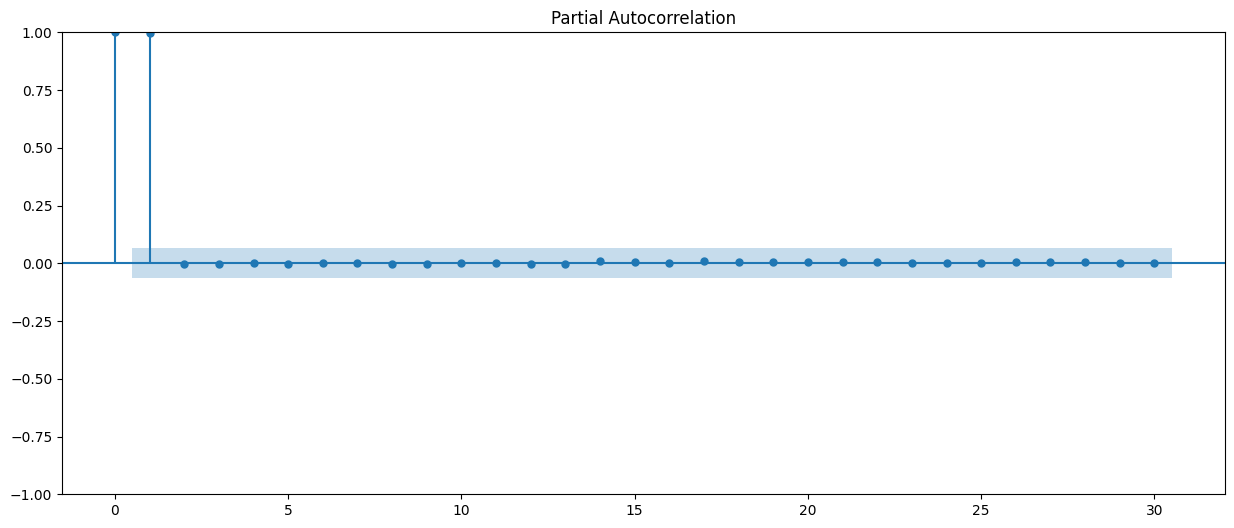

Iteration:      1,   Func. Count:      8,   Neg. LLF: 25231.250815473322
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4852.763663568419
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4853.574759673278
Iteration:      4,   Func. Count:     32,   Neg. LLF: 4852.172587451505
Iteration:      5,   Func. Count:     39,   Neg. LLF: 4851.580353454576
Iteration:      6,   Func. Count:     46,   Neg. LLF: 4851.166195662123
Iteration:      7,   Func. Count:     53,   Neg. LLF: 4851.075648041653
Iteration:      8,   Func. Count:     60,   Neg. LLF: 4850.577099539891
Iteration:      9,   Func. Count:     67,   Neg. LLF: 4847.931775430832
Iteration:     10,   Func. Count:     74,   Neg. LLF: 4829.285889477993
Iteration:     11,   Func. Count:     81,   Neg. LLF: 4800.793803520404
Iteration:     12,   Func. Count:     88,   Neg. LLF: 4828.949046726799
Iteration:     13,   Func. Count:    103,   Neg. LLF: 4807.071158802233
Iteration:     14,   Func. Count:    112,   Neg. LLF: 4799.0693

In [231]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

forecast = GARCH_model("CPI", 2 ,2)
print("\nPredicting volatility")

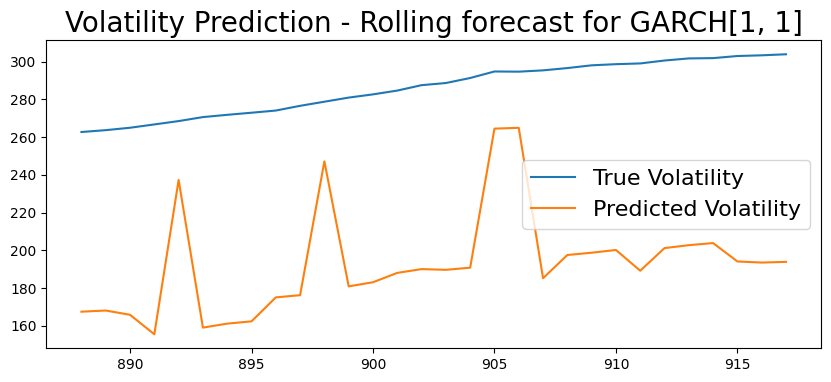

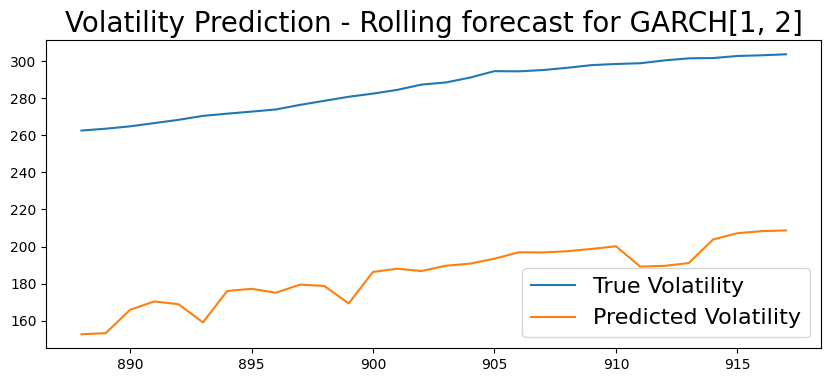

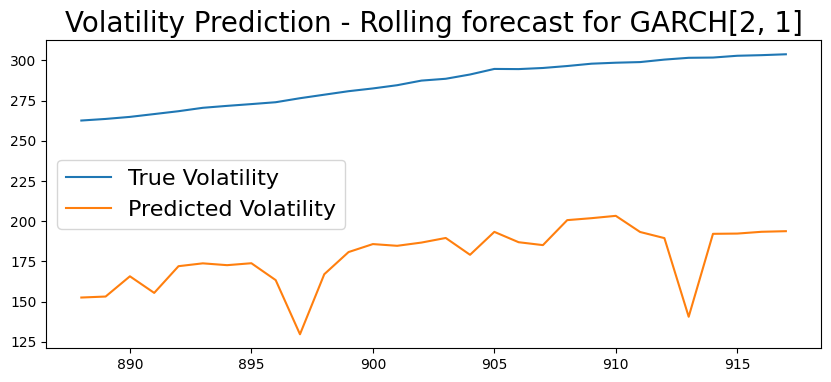

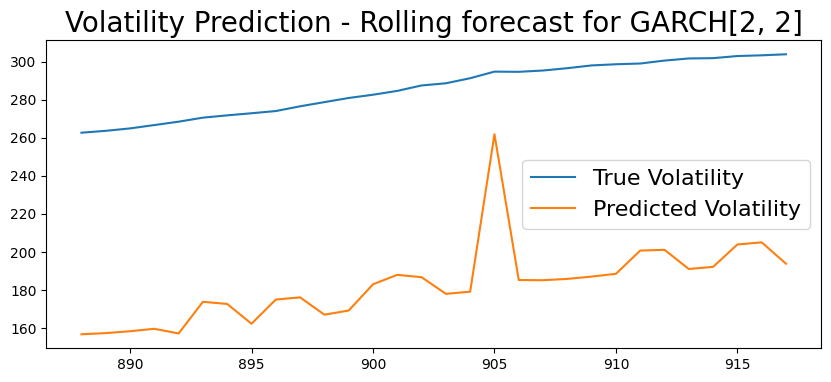

In [232]:
import numpy as np

for i in range(2):
  for j in range(2):
    predict_volatility("CPI", i+1, j+1)

In [169]:
X = series[['CPI' ]]
train, test = X[0:-30], X[-30:]

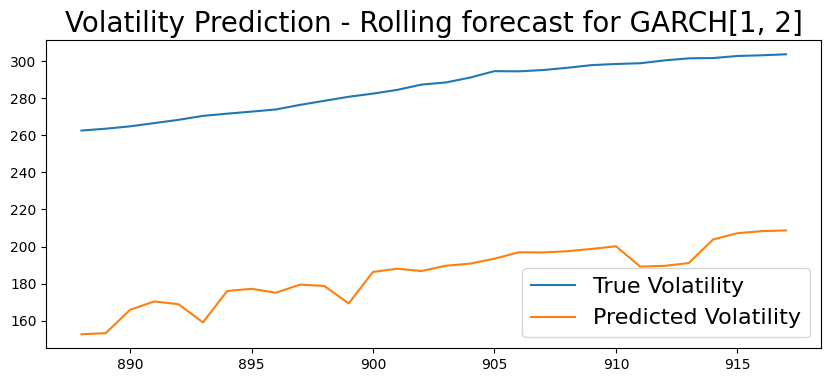

In [233]:
forecast = predict_volatility("CPI", 1, 2)

In [171]:
def timeseries_evaluation_metrics_func(y_true, y_pred , model_name):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'Evaluation metric results for {model_name}:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [172]:
timeseries_evaluation_metrics_func(test, forecast , 'ARCH/GARCH')

Evaluation metric results for ARCH/GARCH:-
MSE is : 10226.836559807833
MAE is : 100.97119107573485
RMSE is : 101.12782287683164
MAPE is : 35.167204516681
R2 is : -54.01288044080331

